<!DOCTYPE html>
<html>
<head>
<style>
* {
  box-sizing: border-box;
}

.column {
  float: left;
  width: 50%;
  padding: 1px;
}

/* Clearfix (clear floats) */
.row::after {
  content: "";
  clear: both;
  display: table;
}


</style>
</head>
<body>

<h2>CNN and Application to lung cancer</h2>
<h3>Width dependence WDTH=8, 16, 24, 32, 48, 56, 64; Resize=350, 400; </h3>
<h3>Running on Kaggle using each of the widths</h3>
<h6 style="color:Tomato;">https://doi.org/10.3390/cancers14225569</h6>

<div class="row">
  <div class="column">
    <img src="cnn.png" alt="General CNN" width=500 height=100>
  </div>
  <div class="column">
    <img src="Celebr.png" alt="CNN celebs, from google images"  width=500 height=100>
  </div>
</div>

</body>
</html>



<h3 style="color: red;">Student: Rexiati Dilimulati </h3>
<h4 style="color: red;">rishat.dilmurat@gmail.com</h4>

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.utils.data import DataLoader, Dataset
from IPython.display import Image, HTML, display
import time
import cv2
from fastai.vision.all import *
import os

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [19]:
torch.manual_seed(0);

In [22]:
#dataset_path = "/kaggle/input/lung_colon_image_set/lung_image_sets"
#print(os.listdir(dataset_path))

<header class="centered-header">
    <h1 style="color:Tomato;">My Mission</h1>
    <h2>Classify Lung Cancer Dataset Using CNN</h2>
</header>
<table><tr><td><img src='typeLungCanser.jpg'  width=600 height=100></td></table>

<h1 style="color:Tomato;">CNN</h1>

In [ ]:
class CNN(nn.Module):

    # Contructor
    def __init__(self, num_conv_layers, size_aftermaxpool, num_classes=10):
        # To initilize the parent nn.Module
        super(CNN, self).__init__()
        
        # To avoid one by one define multiple conv layrs, nn.ModuleList works like list, 
        # which links to nn.Module so that we are able to use module properties. 
        self.conv_layers = nn.ModuleList()
        
        # Define the first layer 
        self.conv_layers.append(nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, padding=1))
        
        # Add subsequent convolutional layers
        for _ in range(1, num_conv_layers):
            self.conv_layers.append(nn.Conv2d(in_channels=24, out_channels=24, kernel_size=3, padding=1))
        
        self.maxpool=nn.MaxPool2d(kernel_size=2)
     
        # Define the fully connected layers
        # CLASSIFICATION
        self.dropout = nn.Dropout(p=0.5)  # Dropout with a 50% probability
        self.fc1 = nn.Linear(24 * size_aftermaxpool * size_aftermaxpool, 512)  
        self.fc2 = nn.Linear(512, 120) 
        self.fc3 = nn.Linear(120, 60)
        self.fc4 = nn.Linear(60, num_classes)
    
    # Prediction
    def forward(self, x):
        for conv in self.conv_layers:
            x = self.maxpool(F.relu(conv(x)))
            #print(x.shape)
        
        # Flatten the output
        #print(x.shape)
        x = x.view(x.size(0), -1)
        
        
        # Forward pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        self.dropout = nn.Dropout(p=0.5)  # Dropout with a 50% probability
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        
        return x


<img src="outputSize.jpg" alt="CNN celebs, from google images"  width=500 height=100>

<h1 style="color:Tomato;">CNN_batch</h1>

<h1 style="color:Tomato;">Train the model</h1>

In [ ]:
def train_model(model, criterion, train_loader, validation_loader, optimizer, n_epochs=4):

    N_train = len(train_loader.dataset)
    N_test = len(validation_loader.dataset)
    accuracy_list_traing = []; loss_list_training = []
    accuracy_list_test = []; loss_list_test = []
    
    for epoch in range(n_epochs):
        model.train()
        cost = 0; correct=0
        for x, y in train_loader:
            x_train = x.as_subclass(torch.Tensor)
            y_train = y.as_subclass(torch.Tensor)
            x_train, y_train = x_train.to(device), y_train.to(device)  # with GPU

            # forward + backward + optimize
            #model.to(device)
            optimizer.zero_grad()
            z = model(x_train)
            loss = criterion(z, y_train)
            loss.backward()
            optimizer.step()
            
            cost = cost+loss.data
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_train).sum().item()
        accuracy = correct / N_train
        accuracy_list_traing.append(accuracy)
        loss_list_training.append(cost.item())
        
        print(f"Epoch_{epoch}:training_accuracy {accuracy:.2f} | training_loss {cost:.2f}")
        
        
        #perform a prediction on the validation  data 
        model.eval()
        cost = 0; correct=0
        for x_test, y_test in validation_loader:
            x_test = x_test.as_subclass(torch.Tensor)
            y_test = y_test.as_subclass(torch.Tensor)
            x_test, y_test = x_test.to(device), y_test.to(device)  # with GPU      
            
            optimizer.zero_grad()
            z = model(x_test)
            loss = criterion(z, y_test)

            cost = cost+loss.data
            _, yhat = torch.max(z.data, 1)
            correct += (yhat == y_test).sum().item()
        accuracy = correct / N_test
        accuracy_list_test.append(accuracy)
        loss_list_test.append(cost.item())

        print(f"Epoch_{epoch}:testing_accuracy {accuracy:.2f} | testing_loss {cost:.2f}")
        
     
    return np.round(np.array([accuracy_list_traing, loss_list_training, accuracy_list_test, loss_list_test], dtype=float), decimals=3)

<h1 style="color:Tomato;">pytorch like loading images</h1>

In [ ]:
""""
# Create the training dataset

# Define a transform (e.g., convert to tensor, normalize)
resize = 225
# 1) with data augmentation
transforms = transforms.Compose([
    transforms.Resize((resize, resize)),  # Resize images to the size expected by Inception v3
    transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally (augmentation)
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])

# 1) without data augmentation
transforms = transforms.Compose([
    transforms.Resize((resize, resize)),  # Resize images to the size expected by Inception v3
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize images
])
# Load the dataset
dataset = dsets.ImageFolder(root="./lung......", transform=transform)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=50, shuffle=True, num_workers=4)
val_loader = DataLoader(dataset=val_dataset, batch_size=50, shuffle=False, num_workers=4)

"""


<h1 style="color:Tomato;">Fastai like loading and showing images</h1>

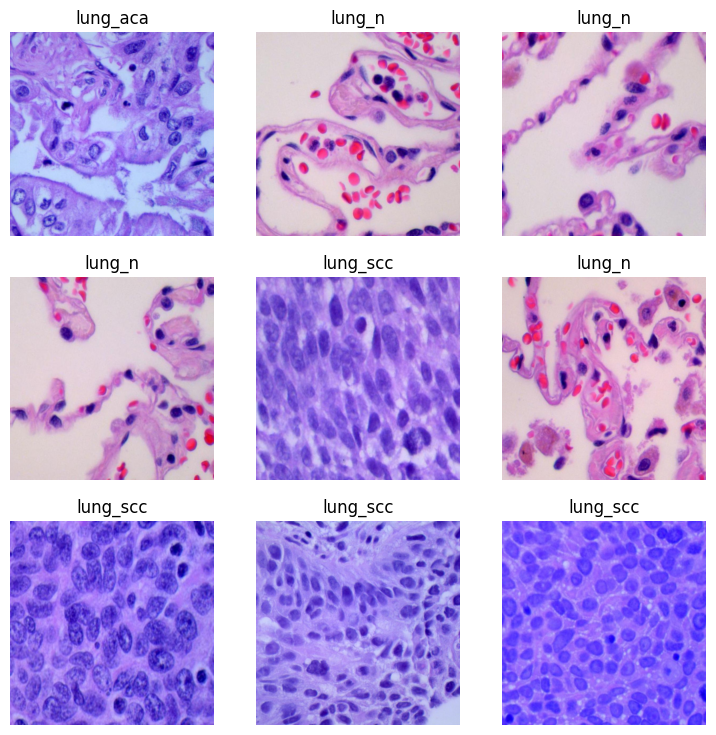

In [25]:
# Path to the directory containing images
dataset_path="../../lung_colon_image_set/lung_image_sets/"
path = Path(dataset_path)

# Create an ImageDataLoaders object
# You can use ImageDataLoaders.from_folder, from_csv, etc., depending on your dataset structure
resize = 400
dls_lungimagesets = ImageDataLoaders.from_folder(
    path, 
    valid_pct=0.2,       # 20% of data will be used for validation
    seed=0,             # Seed for reproducibility
    item_tfms=Resize(resize),# Resize images to 224x224
    bs=50,
    device=device
)

# Get a batch of data
batch = dls_lungimagesets.one_batch()
dls_lungimagesets.show_batch(batch)
# Access the training and validation DataLoaders
train_dls_lungimagesets = dls_lungimagesets.train
valid_dls_lungimagesets = dls_lungimagesets.valid

In [ ]:
len(train_dls_lungimagesets.dataset)

<h1 style="color:Tomato;">With CNN</h1>

In [ ]:
# Create the criterion function
criterion = nn.CrossEntropyLoss()

# Create the parameters
#num_conv_layers = 3

#Increase conv layers
training_results_CNN_ls = []
num_conv_layers=2; 

size_aftermaxpool = int(resize/2**num_conv_layers)
model = CNN(num_conv_layers, size_aftermaxpool).to(device)
#model = SimpleCNN().to(device)
#model = CNN(num_conv_layers).to(device)

# define optimizer
learning_rate = 0.01; momentum=0.9
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)


start_cpu = time.time()
training_results_CNN = train_model(model, criterion, train_dls_lungimagesets, valid_dls_lungimagesets, optimizer, n_epochs=30)
training_results_CNN_ls.append(training_results_CNN)
end_cpu = time.time()

df = pd.DataFrame(training_results_CNN.transpose(), columns=["accuracy_list_traing", "loss_list_training", "accuracy_list_test", "loss_list_test"])
df.to_csv(f"DropOut-in_channels=24-512_CNN.csv", index=False)

print(f'Total time: {(end_cpu - start_cpu)/60:.3f} mins')
#%timeit t_cpu @ t_cpu
#%timeit t_gpu @ t_gpu

In [ ]:
training_results_CNN_ls

<h1 style="color:Tomato;"> With CNN_batch</h1>

In [ ]:
""""
# Create the criterion function
criterion = nn.CrossEntropyLoss()

# Create the parameters
num_conv_layers = 3

#model = CNN_batch(num_conv_layers)
model = CNN_batch(num_conv_layers).to(device)

# define optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# start to play 
start_gpu = torch.cuda.Event(enable_timing=True)
end_gpu = torch.cuda.Event(enable_timing=True)

start_cpu = time.time()
training_results_CNN_batch = train_model(model, criterion, train_loader, validation_loader, optimizer, n_epochs=200)
end_cpu = time.time()

print(f'Total CPU time: {(end_cpu - start_cpu)/60:.3f} mins')
print(f'Total GPU time: {start_gpu.elapsed_time(end_gpu)/(60*1000):.3f} mins')
#%timeit t_cpu @ t_cpu
#%timeit t_gpu @ t_gpu
"""

<h1 style="color:Tomato;">Show results</h1>

In [ ]:
def show_data(data_sample):
    plt.imshow(data_sample[0][0].numpy(), cmap='gray')
    plt.title('y = '+ str(data_sample[1]))

<header class="centered-header">
    <h1 style="color:Tomato;">Results on the resize=400</h1>
    <h2>Training and Testing accuracy</h2>
</header>
<table><tr><td><img src='Training_Val.jpg'  width=600 height=100></td></table>
<table><tr><td><img src='Testing_val.jpg'  width=600 height=100></td></table>

In [ ]:
"""
# Plot the loss and accuracy for CNN

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.plot(torch.tensor(training_results_CNN[1]).numpy(), color=color)
ax1.set_xlabel('epoch', color=color)
ax1.set_ylabel('Cost', color=color)
ax1.tick_params(axis='y', color=color)
plt.title("CNN")
    
ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color) 
ax2.set_xlabel('epoch', color=color)
ax2.plot(training_results_CNN[0], color=color)
ax2.tick_params(axis='y', color=color)
fig.tight_layout()
plt.savefig('LungCancer_CNN_450_450')
"""